<a href="https://colab.research.google.com/github/deebuls/devblog/blob/master/_notebooks/2023-01-26-General-Loss-Function-L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# " General loss fuction: L1, L2, L3 ... "
> Linear, Quadratic, Cubic

- toc: true
- branch: master
- comments: false
- author: Deebul Nair
- image: images/general_loss_function.png
- categories: [deep learning, loss function]

# General Loss Function

The l2 loss function also called the mean square error is the most common loss function. 
The another varition of the loss function is the l1 loss.

The problem with l1 and l2 are that they are not robust to outliers. So can we have a general loss function.

The experiments are not promising but we should look into the "robust loss function" for more details

In [176]:
#hide
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf g

In [177]:

import numpy as np
import matplotlib.pyplot as plt


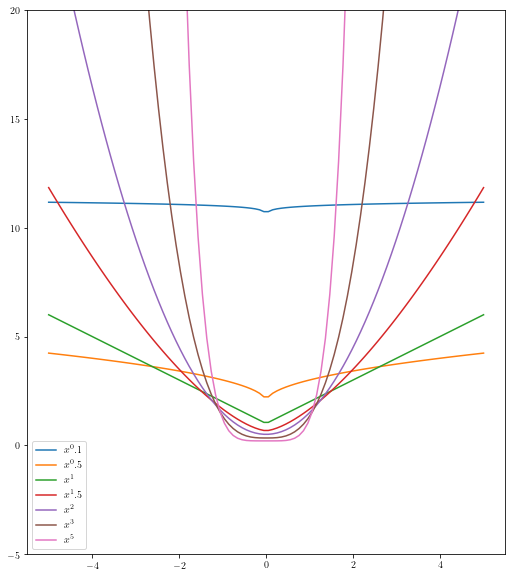

In [192]:
x = np.linspace(-5, 5, 100)

_, ax = plt.subplots(1, 1)
for i in [0.1, 0.5, 1, 1.5, 2, 3, 5]:
   ax.plot(x, np.abs(x)**i + 1/i, label=r"$x^{}$".format(i))

ax.set_ylim(-5,20)
ax.set_aspect(0.5)
ax.legend()

In [193]:
#hide
import sympy.plotting as symplot
import sympy as sym
sym.init_printing(use_unicode=True)

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

color = list(mcolors.TABLEAU_COLORS)

plt.rcParams['figure.figsize'] = 25, 10 #Plot​ Size
plt.rcParams['legend.fontsize']=10 #Legend​ Size

from typing import List,Tuple
from sympy import  print_latex

plt.rcParams['text.usetex'] = True


In [194]:
diff, scale = sym.symbols('diff, scale')

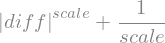

In [195]:
equation = sym.Abs(diff)**scale + 1/scale
equation

$$ \left|{diff}\right|^{scale} + \frac{1}{scale} $$

\left|{diff}\right|^{scale} + \frac{1}{scale}


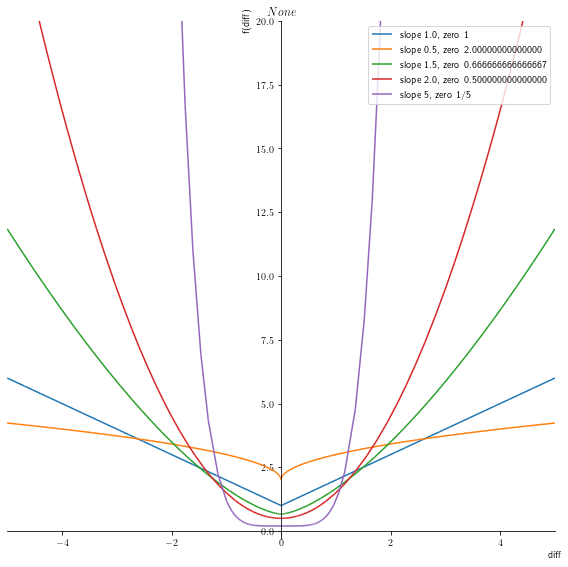

<Figure size 1800x720 with 0 Axes>

In [213]:
#hide_code
p1 = symplot.plot(equation.subs([(scale,1)]), (diff,-5,5), show=False, title = r"$ {} $".format(print_latex(equation)))
p1[0].label = 'slope 1.0, zero %s'% (str(equation.subs([(scale,1), (diff,0)])))
i=0
for s in [0.5, 1.5, 2., 5]:
    p = symplot.plot(equation.subs([(scale,s)]), (diff,-5,5), show=False, line_color=color[i%len(color)+1])
    p[0].label =  'slope %s, zero %s'% (str(s),str(equation.subs([(scale,s), (diff,0)])))
    p1.append(p[0])
    i = i+1


p1.legend = True
p1.ylim = (-0.3, 20)
p1.xlim = (-5., 5)
p1.size = (8,8)

p1.show()
plt.savefig('general_loss_function.png')

## Gradients of the equation

In [211]:
diff_equation = scale * sym.Abs(diff)
diff_equation

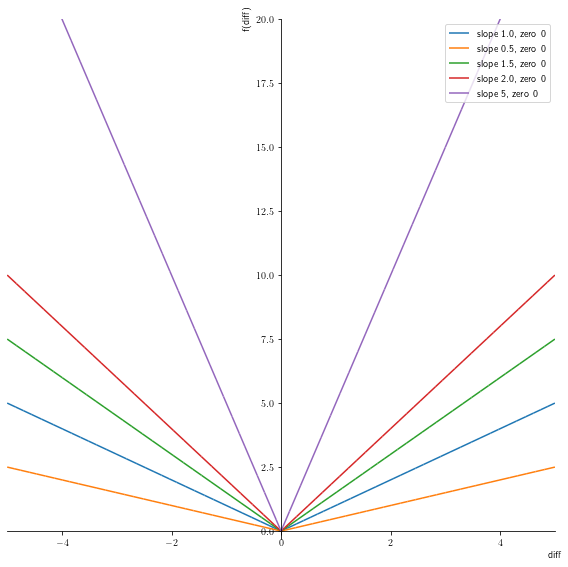

In [212]:
#hide_code
p1 = symplot.plot(diff_equation.subs([(scale,1)]), (diff,-5,5), show=False)
p1[0].label = 'slope 1.0, zero %s'% (str(diff_equation.subs([(scale,1), (diff,0)])))
i=0
for s in [0.5, 1.5, 2., 5]:
    p = symplot.plot(diff_equation.subs([(scale,s)]), (diff,-5,5), show=False, line_color=color[i%len(color)+1])
    p[0].label =  'slope %s, zero %s'% (str(s),str(diff_equation.subs([(scale,s), (diff,0)])))
    p1.append(p[0])
    i = i+1

p1.legend = True
p1.ylim = (-0.3, 20)
p1.xlim = (-5., 5)
p1.size = (8,8)
p1.show()

## Toy dataset 

fitting loss function to the gnerl l2 loss . 

In [55]:
#hide
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

#import seaborn as sns
#sns.set_style('whitegrid')

%matplotlib inline

import imageio
torch.manual_seed(1)    # reproducible

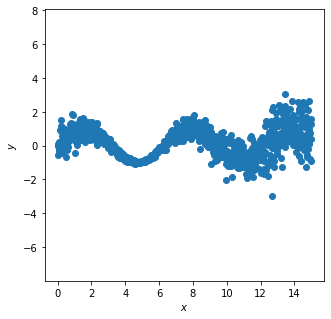

In [146]:
#hide_code
def synthetic_sine_heteroscedastic(
    n_points: int = 10,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return samples from "synthetic sine" heteroscedastic noisy function.
    This returns a synthetic dataset which can be used to train and assess a predictive
    uncertainty model.
    Args:
        n_points: The number of data points in the set.
    Returns:
        - Predicted output points y.
        - Predictive uncertainties, defined using standard deviation of added noise.
        - True output points y.
        - True input points x.
    """
    bounds = [0, 15]

    x = np.linspace(bounds[0], bounds[1], n_points)

    f = np.sin(x)
    std = 0.01 + np.abs(x - 5.0) / 10.0
    noise = np.random.normal(scale=std)
    y = f + noise
    return f, std, y, x

_, _, y, x = synthetic_sine_heteroscedastic(1000)
x = torch.Tensor(x)
y = torch.Tensor(y)
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)
#hide
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x.data.numpy(),y.data.numpy())
ax.axis('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.axis("equal")


In [147]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

# this is one way to define a network
class GaussianNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(GaussianNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.variance = torch.nn.Linear(n_hidden, 1)   # variance layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        out = self.predict(x)             # linear output
        var = F.softplus(self.variance(x))

        return out, var

class GeneralNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(GeneralNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.variance = torch.nn.Linear(n_hidden, 1)   # variance layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        out = self.predict(x)             # linear output
        var = F.softplus(self.variance(x))

        return out, var

In [151]:
def variable_l2_loss(input, target, scale, eps=1e-06, reduction='none'): 
  
  # Inputs and targets much have same shape
  input = input.view(input.size(0), -1)
  target = target.view(target.size(0), -1)
  if input.size() != target.size():
      raise ValueError("input and target must have same size")

  # Second scale of scale must match that of input or be equal to 1
  scale = scale.view(input.size(0), -1)
  if scale.size(1) != scale.size(1) and scale.size(1) != 1:
      raise ValueError("scale is of incorrect size")



  # Check validity of reduction mode
  if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
      raise ValueError(reduction + " is not valid")

  # Entries of var must be non-negative
  if torch.any(scale < 0):
      raise ValueError("scale has negative entry/entries")
  

  # Clamp for stability
  scale = scale.clone()
  with torch.no_grad():
      scale.clamp_(min=eps)

  # Calculate loss (without constant)
  #loss = (torch.log(2*scale) + torch.abs(input - target) / scale).view(input.size(0), -1).sum(dim=1)
  #loss = (torch.abs(input - target)/alpha)**beta - torch.log(beta) + torch.log(2 * alpha ) + torch.lgamma(1/beta)
  loss = torch.abs(input - target)**scale + (1/scale)


  # Apply reduction
  if reduction == 'mean':
      return loss.mean()
  elif reduction == 'sum':
      return loss.sum()
  else:
      return loss

In [152]:
mse_loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
# Fit a linear regression using mean squared error.
regression_mse = Net(n_feature=1, n_hidden=100, n_output=1)     # RegressionModel() 
params_mse = regression_mse.parameters()
optimizer_mse = torch.optim.Adam(params_mse, lr = 0.01) 


gaussian_loss_func = torch.nn.GaussianNLLLoss( reduction='none')
# Fit a linear regression using mean squared error.
regression_gaussian = GaussianNet(n_feature=1, n_hidden=100, n_output=1)     # RegressionModel() 
params_gaussian = regression_gaussian.parameters()
optimizer_gaussian = torch.optim.Adam(params_gaussian, lr = 0.01) 


variable_l2_loss_func = variable_l2_loss
# Fit a linear regression using mean squared error.
regression_general_l2 = GeneralNet(n_feature=1, n_hidden=100, n_output=1)     # RegressionModel() 
params_general_l2 = regression_general_l2.parameters()
optimizer_general_l2 = torch.optim.Adam(params_general_l2, lr = 0.001) 


tensor(4.7806, grad_fn=<MeanBackward0>) tensor(10.1017, grad_fn=<MeanBackward0>) tensor(2.3542, grad_fn=<MeanBackward0>)
tensor(0.5944, grad_fn=<MeanBackward0>) tensor(0.1780, grad_fn=<MeanBackward0>) tensor(1.1948, grad_fn=<MeanBackward0>)
tensor(0.5886, grad_fn=<MeanBackward0>) tensor(0.0654, grad_fn=<MeanBackward0>) tensor(1.0119, grad_fn=<MeanBackward0>)
tensor(0.5829, grad_fn=<MeanBackward0>) tensor(0.0503, grad_fn=<MeanBackward0>) tensor(0.9445, grad_fn=<MeanBackward0>)
tensor(0.5728, grad_fn=<MeanBackward0>) tensor(0.0434, grad_fn=<MeanBackward0>) tensor(0.9182, grad_fn=<MeanBackward0>)
tensor(0.5582, grad_fn=<MeanBackward0>) tensor(0.0369, grad_fn=<MeanBackward0>) tensor(0.8804, grad_fn=<MeanBackward0>)
tensor(0.5438, grad_fn=<MeanBackward0>) tensor(0.0179, grad_fn=<MeanBackward0>) tensor(0.8553, grad_fn=<MeanBackward0>)
tensor(0.5342, grad_fn=<MeanBackward0>) tensor(-0.0407, grad_fn=<MeanBackward0>) tensor(0.8333, grad_fn=<MeanBackward0>)
tensor(0.5288, grad_fn=<MeanBackward0>

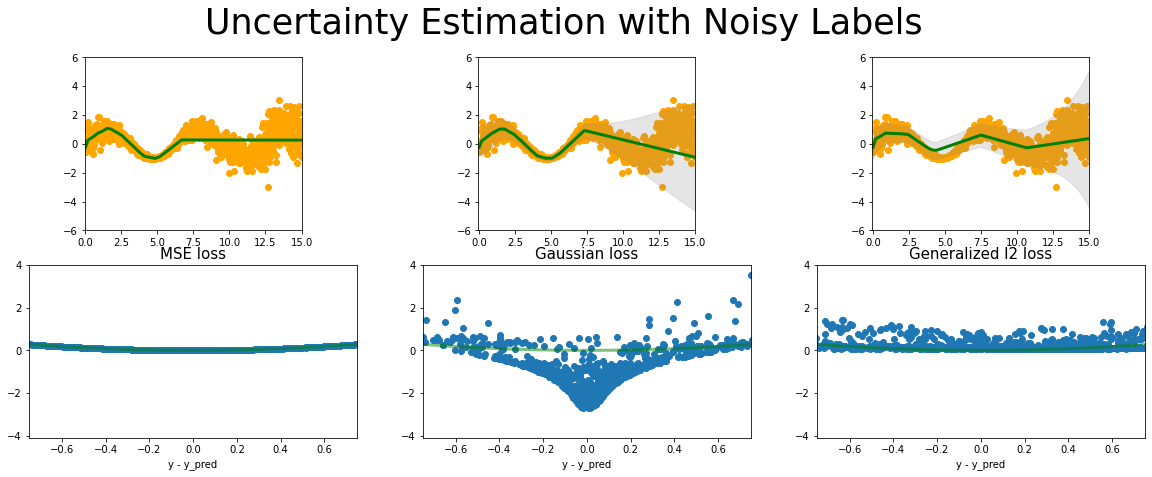

In [153]:
#hide_input

def l2_loss(y, y_):
  return 0.5*(y - y_)**2

my_images = []
fig, axes = plt.subplots(figsize=(20,7), nrows=2, ncols=3)
fig.suptitle('Uncertainty Estimation with Noisy Labels ', fontsize=35)

# train the network
for epoch in range(2000):
    
    #mse loss function
    prediction_mse = regression_mse(x)     # input x and predict based on x
    prediction_gaussian, variances_gaussian = regression_gaussian(x)     # input x and predict based on x
    prediction_general, scale_general = regression_general_l2(x)     # input x and predict based on x
    scale_general = scale_general + 1


    loss_all_mse = mse_loss_func(prediction_mse, y)     # must be (1. nn output, 2. target)
    loss_all_gaussian = gaussian_loss_func(prediction_gaussian, y, variances_gaussian)     # must be (1. nn output, 2. target)
    loss_all_general = variable_l2_loss_func(prediction_general, y, scale_general)     # must be (1. nn output, 2. target)


    loss_mse = torch.mean(loss_all_mse)
    loss_gaussian = torch.mean(loss_all_gaussian)
    loss_general = torch.mean(loss_all_general)


    optimizer_mse.zero_grad()   # clear gradients for next train
    optimizer_gaussian.zero_grad()   # clear gradients for next train
    optimizer_general_l2.zero_grad()   # clear gradients for next train

    loss_mse.backward()         # backpropagation, compute gradients
    loss_gaussian.backward()         # backpropagation, compute gradients
    loss_general.backward()         # backpropagation, compute gradients

    optimizer_mse.step()        # apply gradients
    optimizer_gaussian.step()        # apply gradients
    optimizer_general_l2.step()        # apply gradients


    if np.mod(epoch, 100) == 0:
      
      sort_x, _ = torch.sort(x, dim=0)
      sort_prediction_mse = regression_mse(sort_x)
      sort_prediction_gaussian, sort_variances_gaussian = regression_gaussian(sort_x)
      sort_prediction_general, sort_scale_general = regression_general_l2(sort_x) 
      
      #print (loss_mse, loss_gaussian, loss_general)

      # plot and show learning process
      plt.cla()
      axes[0,0].cla()
      #axes[0,0].set_xlabel('X ', fontsize=24)
      #axes[0,0].set_ylabel('Y', fontsize=24)
      #axes[0,0].axis('equal')
      axes[0, 0].set_aspect('equal', 'box')
      axes[0,0].set_xlim(-0.05, 15)
      axes[0,0].set_ylim(-6, 6)
      #axes[0,0].axis('off')
      axes[0,0].scatter(x.data.numpy(), y.data.numpy(), color = "orange")
      axes[0,0].plot(sort_x.data.numpy(), sort_prediction_mse.data.numpy(), 'g-', lw=3)

      
      axes[0,1].cla()
      #axes[0,1].axis('equal')
      axes[0, 1].set_aspect('equal', 'box')
      axes[0,1].set_xlim(-0.05, 15)
      axes[0,1].set_ylim(-6, 6)
      #axes[0,1].axis('off')
      axes[0,1].scatter(x.data.numpy(), y.data.numpy(), color = "orange")
      axes[0,1].plot(sort_x.data.numpy(), sort_prediction_gaussian.data.numpy(), 'g-', lw=3)
      dyfit = 2 * np.sqrt(sort_variances_gaussian.data.numpy())  # 2*sigma ~ 95% confidence region

      axes[0,1].fill_between( np.squeeze(sort_x.data.numpy()), 
                        np.squeeze(sort_prediction_gaussian.data.numpy() - dyfit),  
                       np.squeeze(sort_prediction_gaussian.data.numpy()  + dyfit),
                 color='gray', alpha=0.2)
      
      
      axes[0,2].cla()
      #axes[0,2].axis('equal')
      axes[0, 2].set_aspect('equal', 'box')
      axes[0,2].set_xlim(-0.05, 15)
      axes[0,2].set_ylim(-6, 6)
      #axes[0,2].axis('off')
      axes[0,2].scatter(x.data.numpy(), y.data.numpy(), color = "orange")
      axes[0,2].plot(sort_x.data.numpy(), sort_prediction_general.data.numpy(), 'g-', lw=3)
      dyfit = 2 * np.sqrt(1/sort_scale_general.data.numpy() ) #* 
                        #  np.random.gamma(3/sort_beta.data.numpy()) / 
                        #  np.random.gamma(1/sort_beta.data.numpy()) )  # 2*sigma ~ 95% confidence region

      axes[0,2].fill_between( np.squeeze(sort_x.data.numpy()), 
                         np.squeeze(sort_prediction_general.data.numpy() - dyfit),  
                       np.squeeze(sort_prediction_general.data.numpy()  + dyfit),
                      color='gray', alpha=0.2)
      

      axes[1,0].cla()
      axes[1,1].cla()
      axes[1,2].cla()

      l2_loss_plot_x = np.linspace(-1,1,num=100)
      axes[1,0].plot(l2_loss_plot_x, 0.5*l2_loss_plot_x**2, color="green", lw=3, alpha=0.5)
      axes[1,1].plot(l2_loss_plot_x, 0.5*l2_loss_plot_x**2, color="green", lw=3, alpha=0.5)
      axes[1,2].plot(l2_loss_plot_x, 0.5*l2_loss_plot_x**2, color="green", lw=3, alpha=0.5)

      diff = prediction_mse.data.numpy() - y.data.numpy()
      axes[1,0].set_title('MSE loss', fontsize=15)
      axes[1,0].scatter(diff,  l2_loss(y, prediction_mse).data.numpy())
      axes[1,0].set_xlabel('y - y_pred')
      axes[1,0].set_ylim(-4.1, 4)
      #axes[1,0].set_aspect('equal', 'box')
      axes[1,0].set_xlim(-0.75, 0.75)

      diff = prediction_gaussian.data.numpy() - y.data.numpy()
      axes[1,1].set_title('Gaussian loss', fontsize=15)
      axes[1,1].scatter(diff,  loss_all_gaussian.data.numpy())
      axes[1,1].set_xlabel('y - y_pred')
      axes[1,1].set_ylim(-4.1, 4)
      #axes[1,1].set_aspect('equal', 'box')
      axes[1,1].set_xlim(-0.75, 0.75)

      diff = prediction_general.data.numpy() - y.data.numpy()
      axes[1,2].set_title('Generalized l2 loss', fontsize=15)
      axes[1,2].scatter(diff,  loss_all_general.data.numpy())
      axes[1,2].set_xlabel('y - y_pred')
      axes[1,2].set_ylim(-4.1, 4)
      #axes[1,2].set_aspect('equal', 'box')
      axes[1,2].set_xlim(-0.75, 0.75)

      # Used to return the plot as an image array 
      # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
      #fig.canvas.draw()       # draw the canvas, cache the renderer
      #image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
      #image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

      #my_images.append(image)

      print (loss_mse, loss_gaussian, loss_general)
plt.savefig('loss_regression.png', bbox_inches='tight', pad_inches = 0)